In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# Implementation

In [2]:
class NoisyDescent:
    def __init__(self,
                 f,
                 x_dim,
                 initial_point=None,
                 max_iter=1000,
                 alpha=0.1,
                 fixed_sigma=None,
                 h=10e-2,
                 diff_method='complex'):
        self.f = f
        self.x_dim = x_dim
        self.initial_point = np.random.randn(x_dim) if initial_point is None else initial_point
        self.max_iter = max_iter
        self.alpha = alpha
        self.fixed_sigma = fixed_sigma
        self.h = h
        self.diff_method = diff_method
        
        # Iteration count
        self.k = 0
        
        self.current_x = self.initial_point
        
        # Values of f at each iteration
        self.values = [self.f(self.current_x)]
        
        # Values of x at each iteration
        self.steps = [self.current_x]
        
        self.optimized = False
        self.optimized_x = None
        
    def optimize(self):
        for _ in range(self.max_iter):
            self.k += 1
            
            # Perform noisy descent step
            grad = self._diff()
            self.current_x = self.current_x - self.alpha * grad + self._noise()
            
            # Store values
            f_value = self.f(self.current_x)
            self.values.append(f_value)
            self.steps.append(self.current_x)
        
        self.optimized = True
        self.optimized_x = self.steps[-1]
        return self.optimized_x
    
    def _sigma(self):
        if self.fixed_sigma is None:
            return 1 / self.k
        return self.fixed_sigma
    
    def _noise(self):
        return np.random.normal(scale=self._sigma(), size=(self.x_dim,))
    
    def _diff(self):
        if self.diff_method == 'complex':
            return self._diff_complex()
        elif self.diff_method == 'numeric':
            return self._diff_numeric()
        return 0
    
    def _diff_complex(self):
        H = np.eye(self.x_dim) * complex(0, self.h)
        result = np.apply_along_axis(lambda x: self.f(x).imag / self.h, 1, self.current_x + H)
        return result
    
    def _diff_numeric(self):
        H = np.eye(self.x_dim) * self.h/2
        left = np.apply_along_axis(self.f, 1, self.current_x - H)
        right = np.apply_along_axis(self.f, 1, self.current_x + H)
        return (right - left) / self.h

# Demo optimizing function 1

Optimizing function:
$$ f_1(x) = x_1^2 - x_2^2 $$

Initialization: $x = \begin{bmatrix} 1 \\ 0 \end{bmatrix} $

In [3]:
f1 = lambda x: x[0]**2 - x[1]**2

## Using noisy descent

Here we optimize $f_1(x)$ using noisy descent with some predefined parameters.

In [4]:
# To reproduce the same result every time
np.random.seed(2)
nd1 = NoisyDescent(f1, x_dim=2, initial_point=np.array([1, 0]), max_iter=30, alpha=0.04, diff_method='numeric')
nd1.optimize()

array([-0.2210216 ,  2.48429218])

### Visualizing descent trace

In [5]:
def visualize_descent(f, steps, x_range, y_range):
    Xs = np.linspace(*x_range, 100)
    Ys = np.linspace(*y_range, 100)

    Xs, Ys = np.meshgrid(Xs, Ys)
    Zs = np.apply_along_axis(f, 2, np.stack([Xs, Ys], axis=2))

    # Plot countour
    plt.figure(figsize=(6, 6))
    plt.contourf(Xs, Ys, Zs)

    # Plot steps taken
    plt.plot(steps[:, 0], steps[:, 1], marker='x', color='w');

    plt.show()

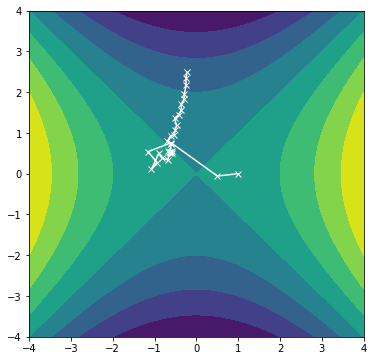

In [6]:
visualize_descent(f1, steps=np.array(nd1.steps), x_range=(-4, 4), y_range=(-4, 4))

### Creating GIF

In [7]:
def create_gif(f, steps, x_range, y_range, file_name):
    Xs = np.linspace(*x_range, 100)
    Ys = np.linspace(*y_range, 100)

    Xs, Ys = np.meshgrid(Xs, Ys)
    Zs = np.apply_along_axis(f, 2, np.stack([Xs, Ys], axis=2))
    
    frames = []
    for i in range(steps.shape[0]):
        # Plot
        plt.contourf(Xs, Ys, Zs)
        plt.plot(steps[:i+1, 0], steps[:i+1, 1], color='white', marker='x')

        # Save GIF frame to buffer
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png')
        plt.close()
        buffer.seek(0)

        # Load and store frame using PIL
        frame = Image.open(buffer)
        frames.append(frame)
        
    # Save frame
    frames[0].save(fp=file_name, format='GIF',
               append_images=frames, save_all=True, duration=100, loop=0)

In [8]:
create_gif(
    f1,
    steps=np.array(nd1.steps),
    x_range=(-4, 4),
    y_range=(-4, 4),
    file_name='animations/f1-noisy-descent.gif'
)

## Using ordinary gradient descent

In [9]:
gd1 = NoisyDescent(f1, x_dim=2,
                  initial_point=np.array([1, 0]),
                  max_iter=30,
                  alpha=0.04,
                  fixed_sigma=0, # Using sigma = 0 removes the noise -> fall back to gradient descent
                  diff_method='numeric')
gd1.optimize()

array([0.0819662, 0.       ])

### Visualizing descent trace

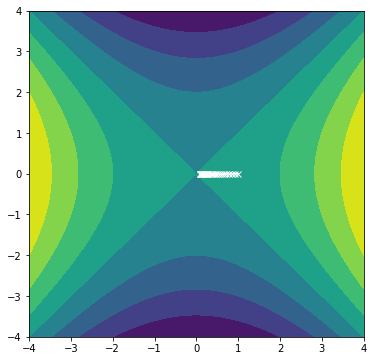

In [10]:
visualize_descent(f1, steps=np.array(gd1.steps), x_range=(-4, 4), y_range=(-4, 4))

### Creating GIF

In [11]:
create_gif(
    f1,
    steps=np.array(gd1.steps),
    x_range=(-4, 4),
    y_range=(-4, 4),
    file_name='animations/f1-gradient-descent.gif'
)

## Comparing how noisy descent and gradient descent reduce f

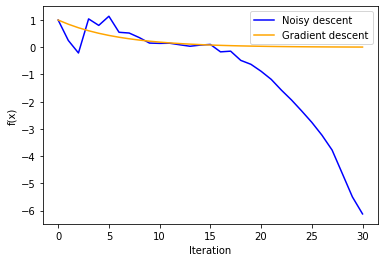

In [12]:
plt.plot(nd1.values, color='blue')
plt.plot(gd1.values, color='orange')
plt.xlabel('Iteration')
plt.ylabel('f(x)')
plt.legend(['Noisy descent', 'Gradient descent'])
plt.show()

# Demo optimizing function 2

Optimizing function:
$$ f(x) = \sin x_1 - \cos x_2 $$

Initialization: $x = \begin{bmatrix} 0.5 \\ 0.3 \end{bmatrix} $

## Using noisy descent

In [13]:
f2 = lambda x: np.sin(x[0]) + np.cos(x[1])

In [14]:
np.random.seed(10)
nd2 = NoisyDescent(f2, x_dim=2, initial_point=np.array([0.5, 0.3]), max_iter=50, alpha=0.1, diff_method='numeric')
nd2.optimize()

array([-1.44829984,  3.07699092])

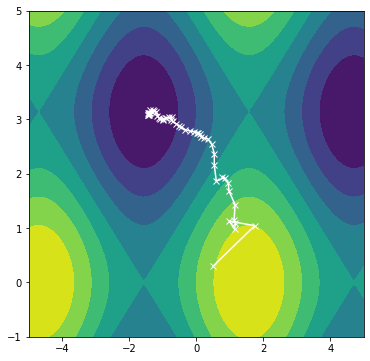

In [15]:
visualize_descent(f2, np.array(nd2.steps), x_range=(-5, 5), y_range=(-1, 5))

In [16]:
create_gif(f2, np.array(nd2.steps), x_range=(-5, 5), y_range=(-1, 5), file_name='animations/f2-noisy-descent.gif')

## Using gradient descent

In [17]:
gd2 = NoisyDescent(f2, x_dim=2, initial_point=np.array([0.5, 0.3]), max_iter=50, alpha=0.1, fixed_sigma=0, diff_method='numeric')
gd2.optimize()

array([-1.55205026,  3.05783791])

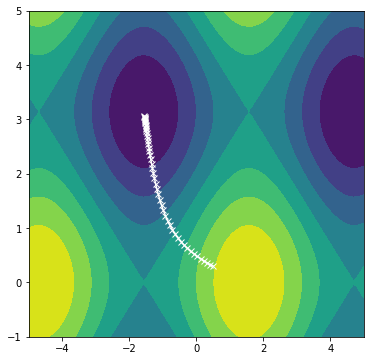

In [18]:
visualize_descent(f2, np.array(gd2.steps), x_range=(-5, 5), y_range=(-1, 5))

In [19]:
create_gif(f2, np.array(gd2.steps), x_range=(-5, 5), y_range=(-1, 5), file_name='animations/f2-gradient-descent.gif')

## Comparing how noisy descent and gradient descent reduce f

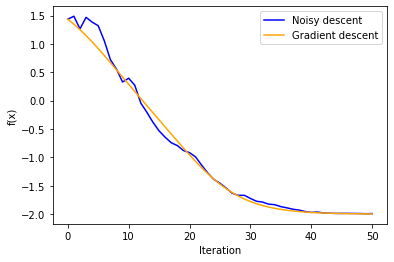

In [20]:
plt.plot(nd2.values, color='blue')
plt.plot(gd2.values, color='orange')
plt.xlabel('Iteration')
plt.ylabel('f(x)')
plt.legend(['Noisy descent', 'Gradient descent'])
plt.show()

In [21]:
true_local_minimum = np.array([-np.pi/2, np.pi])

print(f'True local minimum: {true_local_minimum}')
print(f'Noisy descent result: {nd2.optimized_x}')
print(f'Gradient descent result: {gd2.optimized_x}')

print(f'Distance from true local minimum (noisy descent): {np.sqrt(np.sum((nd2.optimized_x - true_local_minimum)**2))}')
print(f'Distance from true local minimum (gradient descent): {np.sqrt(np.sum((gd2.optimized_x - true_local_minimum)**2))}')

True local minimum: [-1.57079633  3.14159265]
Noisy descent result: [-1.44829984  3.07699092]
Gradient descent result: [-1.55205026  3.05783791]
Distance from true local minimum (noisy descent): 0.13848744372571076
Distance from true local minimum (gradient descent): 0.08582699241443623
